In [1]:
import pickle
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.model_selection import train_test_split
from pyts.classification import TimeSeriesForest
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

In [3]:
with open('train/precision_gridsearchcv/X_test_df.pkl', 'rb') as file:
    X_test_df = pickle.load(file)

In [4]:
freqs = list(X_test_df.keys())

In [8]:
def eval_test(X_test_df, forest_freq_clf_list, is_catboost=True):
    X_test_df = pd.DataFrame(X_test_df)
    y_pred = []
    for i in range(X_test_df.shape[0]):
        y_cur_pred = []
        for freq in freqs:
            cur_freq_X = X_test_df.iloc[i][freq]
            if is_catboost:
                cur_freq_X = [str(cur_elem) for cur_elem in cur_freq_X]
            cur_freq_y = forest_freq_clf_list[freq].predict([cur_freq_X])[0]
            y_cur_pred.append(cur_freq_y)
        pred_mode = stats.mode(np.array(y_cur_pred))[0]
        y_pred.append(pred_mode)
    return y_pred


def get_data_stats(train, test):
    print("(train) АКР:", train.count(1))
    print("(train) не АКР:", train.count(0))

    print("(test) АКР:", test.count(1))
    print("(test) не АКР:", test.count(0))


def build_conf_matrix(labels, predict, class_name):
    lab, pred = [], []
    for i in range(len(labels)):
        if predict[i] == class_name:
            pred.append(0)
        else:
            pred.append(1)
        if labels[i] == class_name:
            lab.append(0)
        else:
            lab.append(1)
    return confusion_matrix(lab, pred, normalize='true')


def eval_metrics(y_pred, y_test, id=""):
    print("f1_score: ", f1_score(y_test, y_pred))
    print("precision_score: ", precision_score(y_test, y_pred))
    print("recall_score: ", recall_score(y_test, y_pred))

    get_res = {0: "нет АКР", 1: "АКР"}

    for i in range(2):
        heatmap = sns.heatmap(build_conf_matrix(y_test, y_pred, i), annot=True, cmap='YlGnBu')
        heatmap.set_title(get_res[i], fontdict={'fontsize':14}, pad=10)
        plt.xlabel('Предсказанный класс')
        plt.ylabel('Истинный класс')
        plt.savefig(f"Класс {i} ({id}).png", dpi=300)
        plt.show()


def cleared_test_ds(X_dict, y, threshold=1):
    """
        Функция, которая удаляет из тренировочной выборки последовательности, в
        которых значение напряжения равно нулю больше чем threshold секунд 
    """
    new_X_dict = {}
    bad_idx = []
    # находим для каждой частоты индексы с данными, в которых больше одного 0
    freqs = list(X_dict.keys())
    for freq in freqs:
        cur_freq_test = X_dict[freq]
        for i in range(len(cur_freq_test)):
            if cur_freq_test[i].count(0) > threshold:
                bad_idx.append(i)
    bad_idx = np.unique(np.array(bad_idx)).tolist()
    new_y = pd.DataFrame(y).drop(bad_idx, axis=0).values.tolist()
    new_y = [y[0] for y in new_y]
    # удаляем для каждой частоты объекты с этими индексами (в т.ч. в 'y')
    for freq in freqs:
        cur_freq_test = X_dict[freq]
        new_X = pd.DataFrame(cur_freq_test).drop(bad_idx, axis=0).values.tolist()
        new_X_dict[freq] = new_X
    return new_X_dict, new_y

## Обучил на GridSearchCV, с приоритетом на Precision

обучалось 493 мин.

In [9]:
with open('train/precision_gridsearchcv/X_test_df.pkl', 'rb') as file:
    X_test_df = pickle.load(file)

with open('train/precision_gridsearchcv/freq_clf_list.pkl', 'rb') as file:
    freq_clf_list = pickle.load(file)

with open('train/precision_gridsearchcv/y_train.pkl', 'rb') as file:
    y_train = pickle.load(file)

with open('train/precision_gridsearchcv/y_test.pkl', 'rb') as file:
    y_test = pickle.load(file)


In [10]:
get_data_stats(y_train, y_test)

(train) АКР: 4527
(train) не АКР: 10301
(test) АКР: 1135
(test) не АКР: 2572


In [11]:
new_X_test_df, new_y_test = cleared_test_ds(X_test_df, y_test)

In [12]:
y_pred = eval_test(new_X_test_df, freq_clf_list)

In [13]:
confusion_matrix(y_test, y_pred, normalize='true')

array([[1., 0.],
       [1., 0.]])

f1_score:  0.0
precision_score:  0.0
recall_score:  0.0


c:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


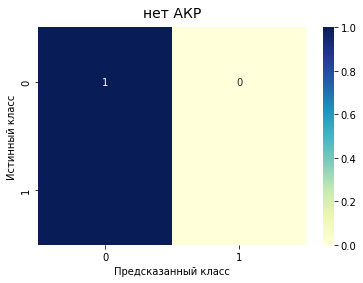

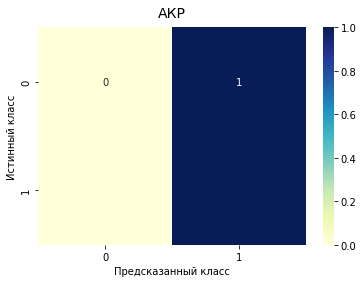

In [14]:
eval_metrics(y_pred, y_test)

## Обучил на GridSearchCV, с приоритетом на Accuracy

выборка выровнена, 418 минут обучалось

In [46]:
with open('train/accuracy_gridsearchcv/balanced_X_test_df.pkl', 'rb') as file:
    X_test_df = pickle.load(file)

with open('train/accuracy_gridsearchcv/balanced_freq_clf_list.pkl', 'rb') as file:
    freq_clf_list = pickle.load(file)

with open('train/accuracy_gridsearchcv/balanced_y_train.pkl', 'rb') as file:
    y_train = pickle.load(file)

with open('train/accuracy_gridsearchcv/balanced_y_test.pkl', 'rb') as file:
    y_test = pickle.load(file)


In [47]:
get_data_stats(y_train, y_test)

(train) АКР: 4512
(train) не АКР: 4547
(test) АКР: 1150
(test) не АКР: 1115


In [48]:
new_X_test_df, new_y_test = cleared_test_ds(X_test_df, y_test)

In [49]:
y_pred = eval_test(new_X_test_df, freq_clf_list)

In [50]:
confusion_matrix(y_test, y_pred, normalize='true')

array([[1., 0.],
       [1., 0.]])

f1_score:  0.0
precision_score:  0.0
recall_score:  0.0


c:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


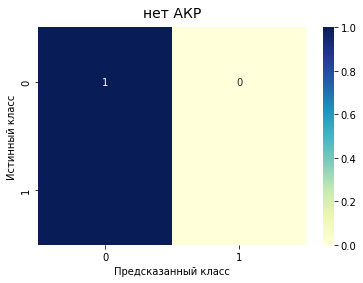

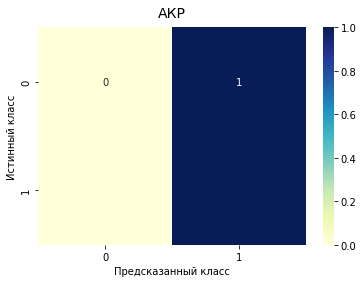

In [52]:
eval_metrics(y_pred, y_test)

# kNN

3 min

In [6]:
with open('train/knn/balanced_X_test_df.pkl', 'rb') as file:
    X_test_df = pickle.load(file)

with open('train/knn/balanced_freq_clf_list.pkl', 'rb') as file:
    freq_clf_list = pickle.load(file)

with open('train/knn/balanced_y_train.pkl', 'rb') as file:
    y_train = pickle.load(file)

with open('train/knn/balanced_y_test.pkl', 'rb') as file:
    y_test = pickle.load(file)

get_data_stats(y_train, y_test)

(train) АКР: 4512
(train) не АКР: 4547
(test) АКР: 1150
(test) не АКР: 1115


In [7]:
def eval_test(X_test_df, forest_freq_clf_list):
    X_test_df = pd.DataFrame(X_test_df)
    y_pred = []
    for i in range(X_test_df.shape[0]):
        y_cur_pred = []
        for freq in freqs:
            cur_freq_X = X_test_df.iloc[i][freq]
            cur_freq_X = cur_freq_X[0]
            cur_freq_y = forest_freq_clf_list[freq].predict([cur_freq_X])[0]
            y_cur_pred.append(cur_freq_y)
        pred_mode = stats.mode(np.array(y_cur_pred))[0]
        y_pred.append(pred_mode)
    return y_pred

f1_score:  0.8058712121212122
precision_score:  0.8846153846153846
recall_score:  0.74


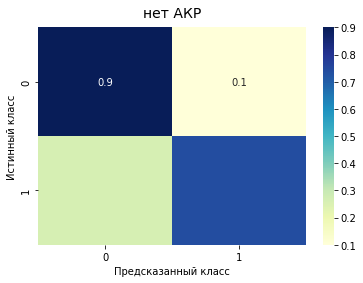

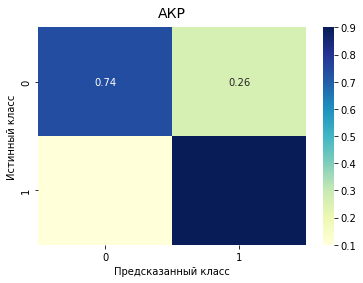

In [8]:
new_X_test_df, new_y_test = cleared_test_ds(X_test_df, y_test)
y_pred = eval_test(new_X_test_df, freq_clf_list)
confusion_matrix(y_test, y_pred, normalize='true')
eval_metrics(y_pred, y_test)

In [9]:
confusion_matrix(y_test, y_pred, normalize='true')

array([[0.90044843, 0.09955157],
       [0.26      , 0.74      ]])

# Forest

In [2]:
import pickle

In [ ]:
with open('train/forest/balanced_X_test_df.pkl', 'rb') as file:
    X_test_df = pickle.load(file)

with open('train/forest/balanced_freq_clf_list.pkl', 'rb') as file:
    freq_clf_list = pickle.load(file)

with open('train/forest/balanced_y_train.pkl', 'rb') as file:
    y_train = pickle.load(file)

with open('train/forest/balanced_y_test.pkl', 'rb') as file:
    y_test = pickle.load(file)

# get_data_stats(y_train, y_test)

NameError: name 'get_data_stats' is not defined

In [7]:
def eval_test(X_test_df, forest_freq_clf_list):
    X_test_df = pd.DataFrame(X_test_df)
    y_pred = []
    for i in range(X_test_df.shape[0]):
        y_cur_pred = []
        for freq in freqs:
            cur_freq_X = X_test_df.iloc[i][freq]
            cur_freq_X = cur_freq_X[0]
            cur_freq_y = forest_freq_clf_list[freq].predict([cur_freq_X])[0]
            y_cur_pred.append(cur_freq_y)
        pred_mode = stats.mode(np.array(y_cur_pred))[0]
        y_pred.append(pred_mode)
    return y_pred

f1_score:  0.8099019149929939
precision_score:  0.8748738647830474
recall_score:  0.7539130434782608


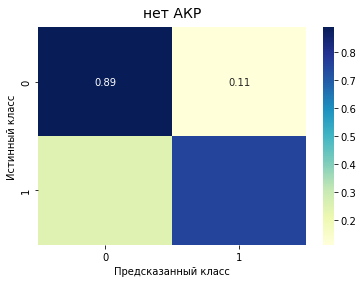

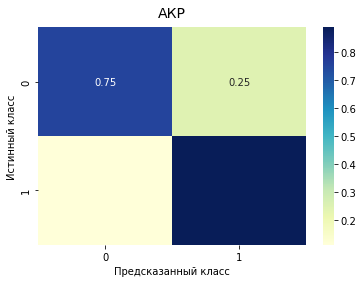

In [8]:
new_X_test_df, new_y_test = cleared_test_ds(X_test_df, y_test)
y_pred = eval_test(new_X_test_df, freq_clf_list)
confusion_matrix(y_test, y_pred, normalize='true')
eval_metrics(y_pred, y_test)

In [ ]:
import pickle

# with open('train/forest/y_pred.pkl', 'wb') as file:
#     pickle.dump(y_pred, file)

In [12]:
with open('train/forest/y_pred.pkl', 'rb') as file:
    kekw = pickle.load(file)
    
confusion_matrix(y_test, kekw, normalize='true')
# eval_metrics(kekw, y_test)

array([[0.88878924, 0.11121076],
       [0.24608696, 0.75391304]])

In [ ]:
confusion_matrix(y_test, kekw, normalize='true')